In [19]:
!nvidia-smi

Mon Nov 16 18:06:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |   5611MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import csv
import json
import pandas as pd
import numpy as np
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import notebook
import itertools
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
from datetime import date
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from transformers import (XLNetTokenizer,
                          XLNetConfig,
                          XLNetForSequenceClassification,
                          AdamW,
                          get_cosine_schedule_with_warmup)

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [3]:
def regex_filter(df):
    df["final_utterance"] = df["final_utterance"].str.lower()

    regex_patterns={
      # replace "uh.," "um.," "ah.," "mm.,", "oh.,!?" with blank but we leave uh-hum/mm-hmm in there
      r'(\buh(\,|\.|\s|\?))': ' ',
      r'(\bum(\,|\.|\s|\?))': ' ',
      r'(\bah\W)': ' ',
      r'(\bmm(\,|\.|\s|\!|\?))': ' ',
      r'(\boh(\,|\.|\s|\!|\?))': ' ',

      r'(\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})?[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*)': ' ', # remove 10 digit and 7 digit numbers  e.g., 456-123-0000 and 123-0000
      r'(\d{3,})': '', # remove any numbers that has length 3 or more 
      r'\b(\w+)((?:\W+?)(\s+)?\1\b)+': r'\1', # replaces duplicate words with a single instance of that word. "yup, yup thank thank you. bye-bye" -> "yup thank you. bye" 
      r'([a-zA-Z0-9._-]+(\s+)?@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)': '[email]',
      r'(\bok\b)': 'okay',  #replaces "ok" with "okay"
      r'(ma\'am)': 'madam', #replaces ma'am with madam 
      r'(\s{2,})': ' '#replaces 2 or more whitespaces with a single one
    }

    df['final_utterance'].replace(regex=regex_patterns, inplace=True)
    df['final_utterance'] = df['final_utterance'].str.strip() 

    return df

def get_duration_col(df, has_response=True):
    df_min = df.groupby(['call_id'])['time_start'].min().reset_index()
    df_max = df.groupby(['call_id'])['time_end'].max().reset_index()
    df_time = pd.merge(df_min, df_max, on='call_id')
    df_time['duration'] = df_time.time_end - df_time.time_start

    # combine all the utterances grouped by the call_id into a single conversation. 
    if has_response:
        df_combined = df.groupby(['call_id', 'response_value']).agg({'final_utterance': ' '.join}).reset_index()
        dfr = pd.merge(df_combined, df_time[['call_id', 'duration']], on='call_id')
    else:
        df_combined = df.groupby(['call_id']).agg({'final_utterance': ' '.join}).reset_index()
        dfr = pd.merge(df_combined, df_time[['call_id', 'duration']], on='call_id')

    return dfr

def encode_labels(df):
    filter_method = lambda x: 0 if x < 3 else 1 if (x >3) else None
    df['response_value'] = df.response_value.apply(filter_method)
    df = df[df['response_value'].notna()]

    return df

def exclude_disconnected_calls(df):
    dfn = df[df.text_length.gt(30)].reset_index()

    dfn["last_10_words"] = dfn['text'].str.split().str[-10:].str.join(" ").str.strip() 
    dfn["last_65_words"] = dfn['text'].str.split().str[-65:].str.join(" ").str.strip() 

    dropcall_words = ['one moment', 'hello', 'hold on', 'on hold', 'brief hold', 'hang tight','one second', 'breaking up', 'breaking in', 'transfer', 'hear me', 'hear you', 'hung up', 'disconnect']
    bye_words = ['bye', 'see you', 'talk to you', 'appreciate', 'good', 'great']
    survey_words = ['following this call','participate','survey','one question','bye','great day','great weekend','good day', 'good weekend', 'wonderful day', 'wonderful weekend','see you','welcome']

    # drop all calls related to disconnection / does not make sense / seem to get disconnected unexpectedly.
    dfn = dfn[~((dfn.text_length < 100) & 
          ((dfn['last_10_words'].str.contains('|'.join(dropcall_words))) | (~dfn['last_10_words'].str.contains('|'.join(bye_words)))))]

    #There seems to be many calls where the agent explicitly tells the customer that there will be a one question survey at the end of the call 
    #so to exclude these calls, i'll search for particular strings in the last 65 words. 
    dfn = dfn[~((dfn.text_length >= 100) & 
      (
          ((dfn['last_10_words'].str.contains('|'.join(dropcall_words))) & (~dfn['last_10_words'].str.contains('|'.join(bye_words)))) | 
          ((dfn['last_10_words'].str.contains('|'.join(dropcall_words))) & (~dfn['last_65_words'].str.contains('|'.join(survey_words))))
      )
    )]

    return dfn

def get_last_768_tokens(text):
    #We tokenize using XLNet's sentencepiece tokenizer into their respective ids and take only the last 768 tokens
    ids = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(inputs)[-768:]) for inputs in notebook.tqdm(text)]

    #We decode the ids back into text to use the encode_plus function
    ids_to_text = [tokenizer.decode(inputs) for inputs in notebook.tqdm(ids)]

    return ids_to_text

In [4]:
project_id = 'talkiq-data'
client = bigquery.Client(project=project_id)

#This table contains the calls that are similar to the 1536, oversampled experiment but with 400 fewer calls because they are removed from data_science_pii.final_utterance
query = """
SELECT *
FROM `talkiq-data.ai_research.csat_2_call_sides_utterances_v1`
"""

df = client.query(query).to_dataframe() 
df = regex_filter(df)

#remove all punctuation 
df['text'] = df['final_utterance'].str.replace(r'[^\w\s]+', ' ')
df['text_length'] = df['text'].str.split().str.len()

df.head()

,company_id,company_name,call_id,call_side,final_utterance,response_value,duration,PARTITIONTIME,text,text_length
0,5539601739481088,INDECS,4503952611147776,caller,it's too much holding. mr. qazi okay. so each ...,1.0,1665.545,2020-05-26 00:00:00+00:00,it s too much holding mr qazi okay so each ...,1060
1,5539601739481088,INDECS,4503952611147776,callee,"hi, chiffon hobby you.,fine, let me give it a ...",1.0,1665.545,2020-05-26 00:00:00+00:00,hi chiffon hobby you fine let me give it a o...,1758
2,4507880442626048,Ace Solves It All,4506745656901632,callee,"just call me.,okay., ,yes, i do., okay.,yeah,...",1.0,363.480,2020-06-02 00:00:00+00:00,just call me okay yes i do okay yeah sur...,30
3,4507880442626048,Ace Solves It All,4506745656901632,caller,"thank you for calling a cellphone, all this is...",1.0,363.480,2020-06-02 00:00:00+00:00,thank you for calling a cellphone all this is...,113
4,5171131407663104,Roadrunner Financial,4508112631693312,caller,"thanks for holding mister, he'll, i do apologi...",0.0,337.251,2020-06-08 00:00:00+00:00,thanks for holding mister he ll i do apologi...,329


In [5]:
from torch.utils.data import DataLoader
from transformers import (XLNetConfig,
                        XLNetForSequenceClassification,
                        AdamW,
                        get_cosine_schedule_with_warmup)

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
df['last_768_tokens_text'] = get_last_768_tokens(df.text)

In [ ]:
df.groupby(['response_value'])['call_id'].nunique()

In [ ]:
print(df.groupby(['response_value'])['call_id'].nunique(),"\n")

#15.03% = minority class
print("Minority Class %:", df.groupby(['response_value'])['call_id'].nunique()[0] / (df.groupby(['response_value'])['call_id'].nunique()[0] + df.groupby(['response_value'])['call_id'].nunique()[1])*100)

In [ ]:
#Pivot the df such that we have each call side's transcripts to be a column
df_pivot=df.set_index(['call_id','call_side','response_value']).unstack('call_side').last_768_tokens_text.reset_index().drop(np.nan, axis=1)
df_pivot=df_pivot.rename(columns={'caller':'last_768_tokens_caller', 'callee':'last_768_tokens_callee'})
df_pivot.head()

In [ ]:
#filter out calls where the last_768_tokens_callee and last_768_tokens_caller columns are both null. Upon investigation, these 443 calls were actually removed
#from `data_science_pii.tastes_utterances_final`
df_pivot = df_pivot[~((df_pivot['last_768_tokens_callee'].isna()) & (df_pivot['last_768_tokens_caller'].isna()))]
df_pivot[['last_768_tokens_callee','last_768_tokens_caller']] = df_pivot[['last_768_tokens_callee','last_768_tokens_caller']].fillna('')

## Checking class distribution

In [ ]:
df_pivot.response_value.value_counts()

## Train / Valid / Test Stratified Split

To get train, validation and test set, we need to perform 2 splits.
* First, we split the original dataframe for a 80-20 split. 
* Next, we split the former 20%-split by 50/50 to get our validation and test set. 

**More importantly, we stratify the split so that we maintain the same class imbalance ratio for train, valid and test sets**

In [ ]:
#This csv files are the original train, valid, test sets that were used to train the 1536, oversampling model (Check 1536_VS_768 tab, cell A5)
#Since the aim is to replicate the training of that model but with 2 call sides, we use this datasets to extract the call ids 
df_train1 = pd.read_csv('/home/jupyter/XLNet_1536_2callsides_v1/df_train_1536_b5.csv')
df_valid1 = pd.read_csv('/home/jupyter/XLNet_1536_2callsides_v1/df_valid_1536_b5.csv')
df_test1 = pd.read_csv('/home/jupyter/XLNet_1536_2callsides_v1/df_test_1536_b5.csv')

df_train = df_pivot[df_pivot.call_id.isin(df_train1.call_id)].rename(columns={"last_768_tokens_callee":"callee_text", "last_768_tokens_caller":"caller_text"})
df_valid = df_pivot[df_pivot.call_id.isin(df_valid1.call_id)].rename(columns={"last_768_tokens_callee":"callee_text", "last_768_tokens_caller":"caller_text"})
df_test = df_pivot[df_pivot.call_id.isin(df_test1.call_id)].rename(columns={"last_768_tokens_callee":"callee_text", "last_768_tokens_caller":"caller_text"})
print("Train size:", len(df_train), "\nValidation size:", len(df_valid), "\nTest size:", len(df_test),"\n")

#Check to see that we have successfully divided and stratified the data correctly for train, validation, and test set
print("Train low csat class count:", df_train.response_value.value_counts()[0])
print("Train high csat class count:", df_train.response_value.value_counts()[1])
print("Minority class imbalance %:",df_train.response_value.value_counts()[0]/len(df_train),"\n")

print("Validation low csat class count:", df_valid.response_value.value_counts()[0])
print("Validation high csat class count:", df_valid.response_value.value_counts()[1])
print("Minority class imbalance %:", df_valid.response_value.value_counts()[0]/len(df_valid),"\n")

print("Test low csat class count:", df_test.response_value.value_counts()[0])
print("Test high csat class count:", df_test.response_value.value_counts()[1])
print("Minority class imbalance %:", df_test.response_value.value_counts()[0]/len(df_test))

In [148]:
# Write the DataFrame to CSV file.
with open('/home/jupyter/XLNet_1536_2callsides_v1/df_train.csv', 'w') as f:
    df_train.to_csv(f)

with open('/home/jupyter/XLNet_1536_2callsides_v1/df_valid.csv', 'w') as f:
    df_valid.to_csv(f)

with open('/home/jupyter/XLNet_1536_2callsides_v1/df_test.csv', 'w') as f:
    df_test.to_csv(f)

## Oversampling Training Data For Class Imbalance

To deal with class imbalance, we will oversample the training data so that the classes will be balanced (50/50)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority", random_state=42)

#Resample our text and values data 
X_train_resampled, y_train_resampled = ros.fit_resample(df_train[['call_id','caller_text','callee_text']], df_train[['response_value']])

#Check to make sure the minority class is now balanced.
print("Class balance:", y_train_resampled.response_value.value_counts()[0] / len(y_train_resampled))

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs. 
# Set max length to 1539 because +3 is for special tokens [CLS] and [SEP] for 2 call sides (each call side is 768 tokens long)
train_encoded_inputs = [tokenizer.encode_plus(X_train_resampled.caller_text[ind], X_train_resampled.callee_text[ind], return_token_type_ids=True, add_special_tokens = True, max_length=1539, padding='max_length', truncation='only_first', return_tensors='pt') for ind in notebook.tqdm(X_train_resampled.index)]

#Creating a tensor dataset with the ENCODED inputs, labels and attention & token type id tensors.  
train_inputs_tensor = torch.cat([x['input_ids'] for x in train_encoded_inputs])
train_token_type_ids_tensor = torch.cat([x['token_type_ids'] for x in train_encoded_inputs]) #we need token_type_ids to identify between the 2 call sides
train_attn_tensor = torch.cat([x['attention_mask'] for x in train_encoded_inputs])
train_labels_tensor = torch.LongTensor(y_train_resampled.response_value.tolist())


#Encoding for valid set
valid_encoded_inputs = [tokenizer.encode_plus(df_valid.caller_text[ind], df_valid.callee_text[ind], return_token_type_ids=True, add_special_tokens = True, max_length=1539, padding='max_length', truncation='only_first', return_tensors='pt') for ind in notebook.tqdm(df_valid.index)]

#Creating a tensor dataset with the ENCODED inputs, labels and attention & token type id tensors.  
valid_inputs_tensor = torch.cat([x['input_ids'] for x in valid_encoded_inputs])
valid_token_type_ids_tensor = torch.cat([x['token_type_ids'] for x in valid_encoded_inputs])
valid_attn_tensor = torch.cat([x['attention_mask'] for x in valid_encoded_inputs])
valid_labels_tensor = torch.LongTensor(df_valid.response_value.tolist())

#Encoding for test set
test_encoded_inputs = [tokenizer.encode_plus(df_test.caller_text[ind], df_test.callee_text[ind], return_token_type_ids=True, add_special_tokens = True, max_length=1539, padding='max_length', truncation='only_first', return_tensors='pt') for ind in notebook.tqdm(df_test.index)]

#Creating a tensor dataset with the ENCODED inputs, labels and attention & token type id tensors.  
test_inputs_tensor = torch.cat([x['input_ids'] for x in test_encoded_inputs])
test_token_type_ids_tensor = torch.cat([x['token_type_ids'] for x in test_encoded_inputs])
test_attn_tensor = torch.cat([x['attention_mask'] for x in test_encoded_inputs])
test_labels_tensor = torch.LongTensor(df_test.response_value.tolist())

In [ ]:
train_df = TensorDataset(train_inputs_tensor, train_token_type_ids_tensor, train_attn_tensor, train_labels_tensor)
valid_df = TensorDataset(valid_inputs_tensor, valid_token_type_ids_tensor, valid_attn_tensor, valid_labels_tensor)
test_df = TensorDataset(test_inputs_tensor, test_token_type_ids_tensor, test_attn_tensor, test_labels_tensor)

#sample subset for debugging 
# aa_df = TensorDataset(train_inputs_tensor[:100], train_token_type_ids_tensor[:100], train_attn_tensor[:100], train_labels_tensor[:100])
# bb_df = TensorDataset(valid_inputs_tensor[:100], valid_token_type_ids_tensor[:100], valid_attn_tensor[:100], valid_labels_tensor[:100])

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class csatXLNet:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    def __init__(self,
                 xlnet_pretrained_model='xlnet-base-cased',
                 freeze_layers = True,
                 train_batch_size=4,
                 eval_batch_size=4,
                 num_labels=2):

        # define hyperparameters
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.num_labels = num_labels

        # loading pre-trained models
        self.config = XLNetConfig.from_pretrained(xlnet_pretrained_model)
        self.config.num_labels = num_labels
        self.model = XLNetForSequenceClassification.from_pretrained(xlnet_pretrained_model, config=self.config).to(self.DEVICE)

        self.train_dset = train_df
        self.eval_dset = valid_df
        self.train_loader = DataLoader(self.train_dset,
                                  batch_size=self.train_batch_size,
                                  shuffle=True)
        self.eval_loader = DataLoader(self.eval_dset,
                                  batch_size=self.eval_batch_size)

        #Freezing all layers except classifier layer
        if freeze_layers:
            for name, param in self.model.named_parameters():
                if 'logits_proj' not in name: # classifier layer for XLNet
                    param.requires_grad = False

    def train_model(self,
                    num_epochs=8,
                    learning_rate=2e-4,
                    warmup_ratio=0.1,
                    experiment_path = '/home/jupyter/XLNet_1536_2callsides_v1/',
                    model_save_path = 'saved_model_epoch_%d/',
                    train_valid_filename = 'train_valid_stats.csv'):
    
        if not os.path.exists(experiment_path):
            os.makedirs(experiment_path)
  
        # Total number of training steps is [number of batches] x [number of epochs]. 
        num_total_steps = len(self.train_loader) * num_epochs 

        num_warmup_steps = int(num_total_steps * warmup_ratio)

        # instantiate optimizer

        # param_optimizer = list(self.model.named_parameters())
        # no_decay = ['bias', 'gamma', 'beta']
        # optimizer_grouped_parameters = [
        #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        #     'weight_decay_rate': 0.01},
        #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        #     'weight_decay_rate': 0.0}
        # ]

        optimizer = AdamW(self.model.parameters(),
                          lr=learning_rate) #default is 5e-5


        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                          num_warmup_steps=num_warmup_steps,
                                          num_training_steps=num_total_steps)

        # define empty lists and counters to keep track of metrics
        train_valid_stats = []
        all_train_loss, all_train_accuracy, all_train_f1score, all_train_precision, all_train_recall = [], [], [], [], []
        all_eval_loss, all_eval_accuracy, all_eval_f1score, all_eval_precision, all_eval_recall = [], [], [], [], []

        self.model.train()

        # loop over dataset for num_epochs
        for epoch in notebook.tqdm(range(num_epochs), desc="Epoch  "):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))

            t0 = time.time()

            # Reset the total loss for every new epoch.
            total_train_loss = 0
            total_train_acc = 0
            total_train_f1 = 0
            total_train_precision = 0
            total_train_recall = 0

            # loop over every batch within the training dataset
            for iter, (inputs, ttids, attns, labels) in enumerate(notebook.tqdm(self.train_loader, desc="Training")):

                # reset optimizer gradient
                optimizer.zero_grad()

                # putting inputs to device
                inputs = inputs.to(self.DEVICE)
                ttids = ttids.to(self.DEVICE)
                attns = attns.to(self.DEVICE)
                labels = labels.to(self.DEVICE)

                # feed to model
                outputs = self.model(inputs,
                                token_type_ids=ttids, 
                                attention_mask=attns,
                                labels=labels)

                loss, scores = outputs[:2]

                total_train_loss += loss.item()

                predictions = torch.argmax(scores, dim=-1)

                # backprop
                loss.backward()
                # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                #Update learning rate
                scheduler.step()

                total_train_acc += accuracy_score(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
                _train_precision, _train_recall, _train_f1, _ = precision_recall_fscore_support(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted')
                total_train_precision += _train_precision
                total_train_recall += _train_recall
                total_train_f1 += _train_f1

                # Progress update every 910 samples.
                # if iter % 910 == 0 and not iter == 0:

                #     # Calculate elapsed time in minutes.
                #     elapsed = format_time(time.time() - t0)

                #     # Report progress.
                #     print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(iter, len(self.train_loader), elapsed))

            # add to totals 
            avg_train_loss = total_train_loss/len(self.train_loader)
            avg_train_acc = total_train_acc/len(self.train_loader)
            avg_train_f1 = total_train_f1/len(self.train_loader)
            avg_train_precision = total_train_precision/len(self.train_loader)
            avg_train_recall = total_train_recall/len(self.train_loader)

            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on our validation set.

            eval_loss, eval_acc, eval_f1, eval_precision, eval_recall, eval_conf_matrix = self.evaluate_model()

            print("  Training Loss: {0:.2f}".format(avg_train_loss), "||", "Evaluation Loss: {0:.2f}".format(eval_loss)) 
            print("  Training Accuracy: {0:.2f}".format(avg_train_acc), "||", "Evaluation Accuracy: {0:.2f}".format(eval_acc))
            print("  Training F1: {0:.2f}".format(avg_train_f1), "||", "Evaluation F1: {0:.2f}".format(eval_f1)) 
            print("  Training Precision: {0:.2f}".format(avg_train_precision), "||", "Evaluation Precision: {0:.2f}".format(eval_precision))
            print("  Training Recall: {0:.2f}".format(avg_train_recall), "||", "Evaluation Recall: {0:.2f}".format(eval_recall))

            print(f"Saving current epoch's training & validation metric file to", experiment_path + train_valid_filename)
            fieldnames = ['Epoch', 'train_loss', 'train_acc', 'train_f1', 'train_precision', 'train_recall', 'valid_loss', 'valid_acc', 'valid_f1', 'valid_precision', 'valid_recall', 'eval_confmat']
            if os.path.isfile(experiment_path + train_valid_filename):         
                with open(experiment_path + train_valid_filename, 'a', newline='') as csvfile:
                    w = csv.DictWriter(csvfile, fieldnames= fieldnames)
                    w.writerow({
                        'Epoch': epoch + 1,
                        'train_loss': avg_train_loss,
                        'train_acc': avg_train_acc,
                        'train_f1': avg_train_f1,
                        'train_precision':avg_train_precision,
                        'train_recall':avg_train_recall,
                        'valid_loss': eval_loss,
                        'valid_acc': eval_acc,
                        'valid_f1': eval_f1,
                        'valid_precision':eval_precision,
                        'valid_recall':eval_recall,
                        'eval_confmat':eval_conf_matrix.tolist()
                    })
            else:
                with open(experiment_path + train_valid_filename, 'w', newline='') as csvfile:
                    w = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    w.writeheader()
                    w.writerow({
                        'Epoch': epoch + 1,
                        'train_loss': avg_train_loss,
                        'train_acc': avg_train_acc,
                        'train_f1': avg_train_f1,
                        'train_precision':avg_train_precision,
                        'train_recall':avg_train_recall,
                        'valid_loss': eval_loss,
                        'valid_acc': eval_acc,
                        'valid_f1': eval_f1,
                        'valid_precision':eval_precision,
                        'valid_recall':eval_recall,
                        'eval_confmat':eval_conf_matrix.tolist()
                    })

            #Saving model for epoch
            modelsave_path_formatted = model_save_path % (epoch+1)
            model_saved_path = os.path.join(experiment_path, modelsave_path_formatted)
            print('Saving model from epoch {:} at {}'.format(epoch+1, model_saved_path))
            if not os.path.exists(model_saved_path):
                os.makedirs(model_saved_path)

            self.model.save_pretrained(model_saved_path)
            torch.save(optimizer.state_dict(), os.path.join(model_saved_path, 'optimizer.pt'))
            torch.save(scheduler.state_dict(), os.path.join(model_saved_path, 'scheduler.pt'))

    def evaluate_model(self):
        self.model.eval()

        total_eval_loss = 0
        total_eval_acc = 0
        total_eval_f1 = 0
        total_eval_recall = 0
        total_eval_precision = 0 
        all_labels = []
        all_predictions = [] 

        with torch.no_grad():
            for (inputs, ttids, attns, labels) in notebook.tqdm(self.eval_loader, desc="Evaluate"):

                # putting inputs to device
                inputs = inputs.to(self.DEVICE)
                ttids = ttids.to(self.DEVICE)
                attns = attns.to(self.DEVICE)
                labels = labels.to(self.DEVICE)

                # feed to model
                outputs = self.model(inputs,
                                     token_type_ids=ttids,  
                                     attention_mask=attns, 
                                     labels=labels)

                loss, scores = outputs[:2]

                predictions = torch.argmax(scores, dim=-1)

                # add loss to total loss
                total_eval_loss += loss.item()

                total_eval_acc += accuracy_score(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
                _eval_precision, _eval_recall, _eval_f1, _ = precision_recall_fscore_support(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='macro')
                total_eval_precision += _eval_precision
                total_eval_recall += _eval_recall
                total_eval_f1 += _eval_f1

                # used to create confusion matrix
                all_labels += labels.cpu().flatten().tolist()
                all_predictions += predictions.cpu().flatten().tolist()

        avg_eval_loss = total_eval_loss/len(self.eval_loader)
        avg_eval_acc = total_eval_acc/len(self.eval_loader)
        avg_eval_f1 = total_eval_f1/len(self.eval_loader)
        avg_eval_precision = total_eval_precision/len(self.eval_loader)
        avg_eval_recall = total_eval_recall/len(self.eval_loader)
        conf_matrix = confusion_matrix(all_labels, all_predictions)

        return avg_eval_loss, avg_eval_acc, avg_eval_f1, avg_eval_precision, avg_eval_recall, conf_matrix

In [ ]:
torch.cuda.empty_cache()
model = csatXLNet()

In [ ]:
model.train_model()


======== Epoch 1 / 8 ========


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Training Loss: 0.63 || Evaluation Loss: 0.50
  Training Accuracy: 0.64 || Evaluation Accuracy: 0.81
  Training F1: 0.63 || Evaluation F1: 0.68
  Training Precision: 0.70 || Evaluation Precision: 0.71
  Training Recall: 0.64 || Evaluation Recall: 0.68
Saving current epoch's training & validation metric file to /home/jupyter/XLNet_1536_2callsides_v1/train_valid_stats.csv
Saving model from epoch 1 at /home/jupyter/XLNet_1536_2callsides_v1/saved_model_epoch_1/

======== Epoch 2 / 8 ========


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



  Training Loss: 0.53 || Evaluation Loss: 0.43
  Training Accuracy: 0.75 || Evaluation Accuracy: 0.83
  Training F1: 0.75 || Evaluation F1: 0.71
  Training Precision: 0.81 || Evaluation Precision: 0.73
  Training Recall: 0.75 || Evaluation Recall: 0.71
Saving current epoch's training & validation metric file to /home/jupyter/XLNet_1536_2callsides_v1/train_valid_stats.csv
Saving model from epoch 4 at /home/jupyter/XLNet_1536_2callsides_v1/saved_model_epoch_4/

======== Epoch 5 / 8 ========



  Training Loss: 0.53 || Evaluation Loss: 0.58
  Training Accuracy: 0.76 || Evaluation Accuracy: 0.74
  Training F1: 0.75 || Evaluation F1: 0.62
  Training Precision: 0.82 || Evaluation Precision: 0.67
  Training Recall: 0.76 || Evaluation Recall: 0.61
Saving current epoch's training & validation metric file to /home/jupyter/XLNet_1536_2callsides_v1/train_valid_stats.csv
Saving model from epoch 5 at /home/jupyter/XLNet_1536_2callsides_v1/saved_model_epoch_5/

======== Epoch 6 / 8 ========



  Training Loss: 0.52 || Evaluation Loss: 0.53
  Training Accuracy: 0.76 || Evaluation Accuracy: 0.77
  Training F1: 0.76 || Evaluation F1: 0.64
  Training Precision: 0.82 || Evaluation Precision: 0.69
  Training Recall: 0.76 || Evaluation Recall: 0.64
Saving current epoch's training & validation metric file to /home/jupyter/XLNet_1536_2callsides_v1/train_valid_stats.csv
Saving model from epoch 6 at /home/jupyter/XLNet_1536_2callsides_v1/saved_model_epoch_6/

======== Epoch 7 / 8 ========


In [20]:
res_df=pd.read_csv('/home/jupyter/XLNet_1536_2callsides_v1/train_valid_stats.csv')
res_df.head(10)

,Epoch,train_loss,train_acc,train_f1,train_precision,train_recall,valid_loss,valid_acc,valid_f1,valid_precision,valid_recall,eval_confmat
0,1,0.627201,0.638553,0.628051,0.697578,0.638553,0.495443,0.805680,0.682903,0.711136,0.681552,"[[186, 158], [362, 1967]]"
1,2,0.550593,0.729737,0.725114,0.792014,0.729737,0.712270,0.635277,0.510933,0.602080,0.506913,"[[285, 59], [917, 1412]]"
2,3,0.539537,0.745750,0.742789,0.807673,0.745750,0.574452,0.749626,0.622934,0.676632,0.614723,"[[246, 98], [572, 1757]]"
3,4,0.532665,0.748797,0.746537,0.810339,0.748797,0.428317,0.831091,0.709381,0.733433,0.710015,"[[194, 150], [302, 2027]]"
4,5,0.525601,0.755320,0.753909,0.817916,0.755320,0.579042,0.738416,0.615325,0.674141,0.607000,"[[251, 93], [607, 1722]]"
5,6,0.520998,0.758287,0.757960,0.821923,0.758287,0.531369,0.767564,0.641405,0.689400,0.635339,"[[233, 111], [511, 1818]]"
6,7,0.517437,0.760372,0.760658,0.824269,0.760372,0.513938,0.777653,0.654623,0.699489,0.649290,"[[228, 116], [479, 1850]]"
7,8,0.516008,0.760613,0.759541,0.821437,0.760613,0.529697,0.768685,0.643555,0.691081,0.637519,"[[232, 112], [507, 1822]]"


In [21]:
validation_loss_epoch = res_df.iloc[res_df['valid_loss'].idxmin()][0]
validation_f1_epoch = res_df.iloc[res_df['valid_f1'].idxmax()][0]
validation_precision_epoch = res_df.iloc[res_df['valid_precision'].idxmax()][0]
validation_recall_epoch = res_df.iloc[res_df['valid_recall'].idxmax()][0]

f"Lowest Validation Loss: Epoch {validation_loss_epoch} || \
Highest Validation F1: Epoch {validation_f1_epoch} || \
Highest Validation Precicision: Epoch {validation_precision_epoch} || \
Highest Validation Recall: Epoch {validation_recall_epoch}"

'Lowest Validation Loss: Epoch 4 || Highest Validation F1: Epoch 4 || Highest Validation Precicision: Epoch 4 || Highest Validation Recall: Epoch 4'

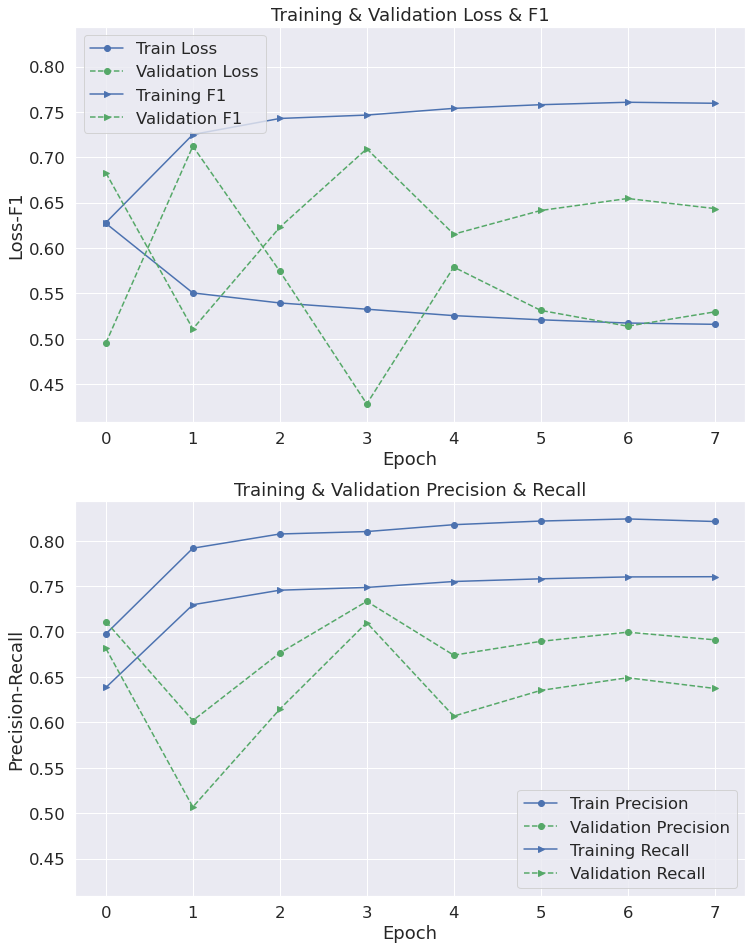

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

# fig, ax = plt.subplots(figsize=(12, 8))    
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True, figsize=(12, 16))

# Plot the learning curve.
ax1.plot(res_df['train_loss'], 'b-o', label="Train Loss")
ax1.plot(res_df['valid_loss'], 'g--o', label="Validation Loss")

ax1.plot(res_df['train_f1'], 'b->', label="Training F1")
ax1.plot(res_df['valid_f1'], 'g-->', label="Validation F1")

ax2.plot(res_df['train_precision'], 'b-o', label="Train Precision")
ax2.plot(res_df['valid_precision'], 'g--o', label="Validation Precision")

ax2.plot(res_df['train_recall'], 'b->', label="Training Recall")
ax2.plot(res_df['valid_recall'], 'g-->', label="Validation Recall")

# Label the plot.
ax1.title.set_text("Training & Validation Loss & F1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss-F1")
ax1.legend()
ax1.set_xticks(res_df['Epoch']-1)

ax2.title.set_text("Training & Validation Precision & Recall")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Precision-Recall")
ax2.legend()
ax2.set_xticks(res_df['Epoch']-1)

plt.show()

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          path=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Parameters
    ----------
    cm: Confusion matrix provided by sklearn

    classes: list of class labels

    normalize: 'True' to normalize confusion matrix. "False" by default.

    path: String that contains the path to save the confusion matrix image

    title: title of the plot

    cmap: A matplotlib color map for the confusion matrix
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(9,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

    print("Saving image..")
    plt.savefig(path)
    print("Image saved at:", path)

    plt.show()

def xlnet_predict(model, test_df, path):
    """Perform a forward pass on the trained XLNet model to predict probabilities
    on the test set.

    Parameters
    ----------
    model: best model from training/validation step

    test_df: Dataframe for the test set being used

    path: Path for the confusion to be saved used by `plot_confusion_matrix()`

    """
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    all_labels = []
    all_predictions = []

    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    test_loader = DataLoader(test_df, batch_size = 8)

    for iter, (inputs, ttids, attns, labels) in enumerate(notebook.tqdm(test_loader, desc="Testing")):
        # putting inputs to device
        inputs = inputs.to(DEVICE)
        ttids = ttids.to(DEVICE)
        attns = attns.to(DEVICE)
        labels = labels.to(DEVICE)

        # feed to model
        with torch.no_grad():
            outputs = model(inputs,
                          token_type_ids=ttids, 
                          attention_mask=attns)
            logits = outputs[0]

            predictions = torch.argmax(logits, dim=-1)
            all_predictions += predictions.cpu().flatten().tolist()
            all_labels += labels.cpu().flatten().tolist()
            

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    conf_mat = confusion_matrix(all_labels, all_predictions)
    print("F1-score:", "%.2f%%" % (f1*100), "\n",
          "\nPrecision:", "%.2f%%" % (precision*100),
          "\nPrecision (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1]) * 100),
          "\nPrecision (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[1][0]) * 100), "\n", 
          "\nRecall:", "%.2f%%" % (recall*100),
          "\nRecall (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0]) * 100),
          "\nRecall (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1]) * 100), "\n"
    )
    plot_confusion_matrix(conf_mat, ["0","1"],path=path)

In [24]:
torch.cuda.empty_cache()

/opt/conda/lib/python3.7/site-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `men_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,



F1-score: 68.75% 
 
Precision: 66.78% 
Precision (CSAT=1):  93.27% 
Precision (CSAT=0):  40.29% 
 
Recall: 72.18% 
Recall (CSAT=1):  87.76% 
Recall (CSAT=0):  56.60% 

Confusion matrix, without normalization
Saving image..
Image saved at: /home/jupyter/XLNet_1536_2callsides_v1/


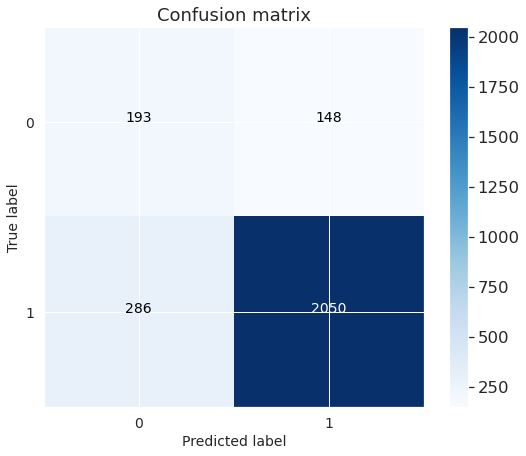

In [25]:
## NEW
saved_conf_mat_path = "/home/jupyter/XLNet_1536_2callsides_v1/"
saved_model_path= "/home/jupyter/XLNet_1536_2callsides_v1/saved_model_epoch_4"
test_model = XLNetForSequenceClassification.from_pretrained(saved_model_path).to('cuda')
xlnet_predict(test_model, test_df, saved_conf_mat_path)

## Notebook ends here

In [565]:
encoded_inputs = []
label_inputs = []

for unique_call_id in notebook.tqdm(df_train2.call_id.unique()):
    agent=df_train2[(df_train2.call_id==unique_call_id) & (df_train2.call_side == 'caller')].last_768_tokens_text.values[0]
    customer=df_train2[(df_train2.call_id==unique_call_id) & (df_train2.call_side == 'callee')].last_768_tokens_text.values[0]
    csat_label=df_train2[(df_train2.call_id==unique_call_id)].response_value.values[0]
    tensor = tokenizer.encode_plus(agent, customer, max_length=1539, padding='max_length', truncation='only_first', return_token_type_ids=True, return_tensors='pt')
    encoded_inputs.append(tensor)
    label_inputs.append(csat_label)
    
#Creating a tensor dataset with the ENCODED inputs, labels and attention tensors.  
inputs_tensor = torch.cat([x['input_ids'] for x in encoded_inputs])
token_type_id_tensor = torch.cat([x['token_type_ids'] for x in encoded_inputs])
attn_tensor = torch.cat([x['attention_mask'] for x in encoded_inputs])
labels_tensor = torch.LongTensor(label_inputs)

tensor_df = TensorDataset(inputs_tensor, token_type_id_tensor, attn_tensor, labels_tensor)

In [72]:
c1 = "hello, this is daniel. how can i help? yes, i would like to purchase a bed. what kind of bed would you like? i'm looking for a double bed"
c2 = "hello, this is daniel. how can i help? what kind of bed would you like?"
c3 = "yes, i would like to purchase a bed. i'm looking for a double bed"
c4 = c2 + c3

inputs1 = tokenizer(c1, return_tensors="pt")
inputs2 = tokenizer(c2, return_tensors="pt")
inputs3 = tokenizer(c3, return_tensors="pt")
inputs4 = tokenizer(c4, return_tensors="pt")
# labels1 = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs1 = model1(**inputs1)
outputs2 = model1(**inputs2)
outputs3 = model1(**inputs3)
outputs4 = model1(**inputs4)

NameError: name 'model1' is not defined

In [137]:
tokenized_text = tokenizer.tokenize(c1 + "cls" + "sep")
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

▁hello       24,717
,                19
▁this            52
▁is              27
▁                17
dan           4,731
iel           9,184
.                 9
▁how            160
▁can             64
▁                17
i               150
▁help           222
?                82
▁yes          4,336
,                19
▁                17
i               150
▁would           74
▁like           115
▁to              22
▁purchase     1,817
▁a               24
▁bed          1,854
.                 9
▁what           113
▁kind           713
▁of              20
▁bed          1,854
▁would           74
▁you             44
▁like           115
?                82
▁                17
i               150
'                26
m                98
▁looking        589
▁for             28
▁a               24
▁double       1,620
▁bed          1,854
cl           11,974
s                23
s                23
ep            3,882


In [142]:
torch.tensor(indexed_tokens)

tensor([24717,    19,    52,    27,    17,  4731,  9184,     9,   160,    64,
           17,   150,   222,    82,  4336,    19,    17,   150,    74,   115,
           22,  1817,    24,  1854,     9,   113,   713,    20,  1854,    74,
           44,   115,    82,    17,   150,    26,    98,   589,    28,    24,
         1620,  1854, 11974,    23,    23,  3882])